# Evaluate Model
Notebook used for evaluating NNs matching parton jets to gen jets

In [98]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import sys

In [99]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [100]:
sys.path.append('../src/')
import model

In [101]:
save_dir = '../models/Run_1_2020-10-06/'
assert(os.path.isdir(save_dir))

In [102]:
losses = np.loadtxt(save_dir + 'losses.csv', delimiter=',', skiprows=1)

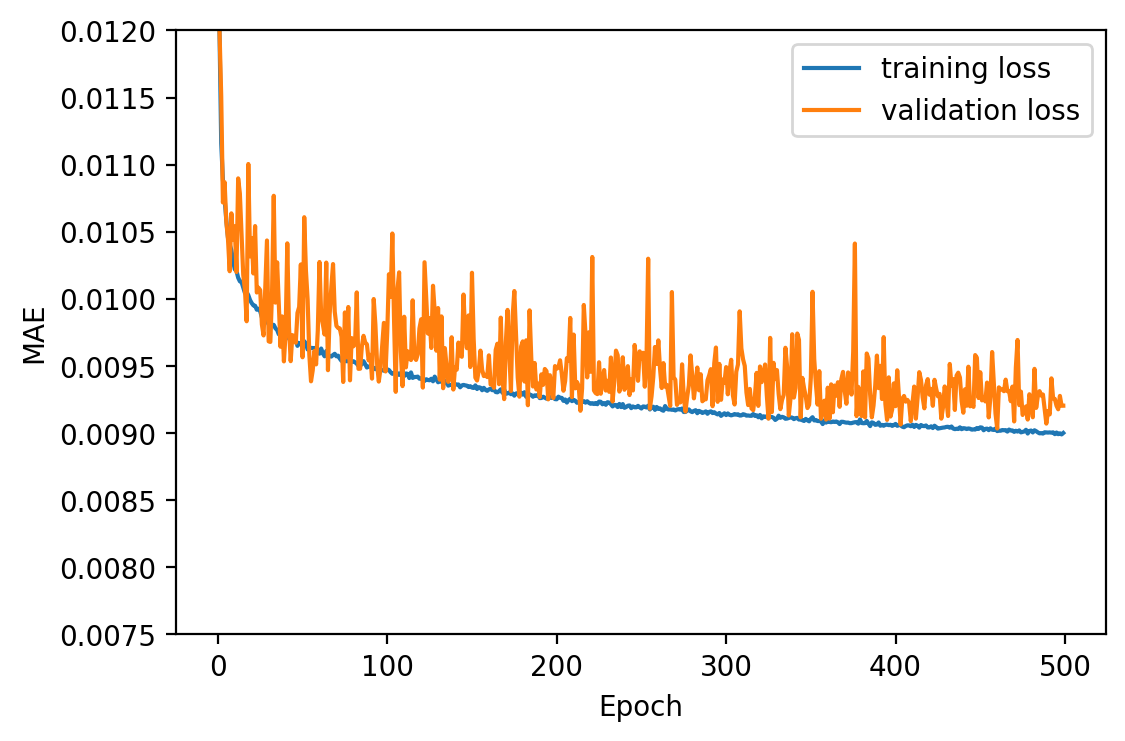

In [105]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)
ax.plot(losses[:, 1], label='training loss')
ax.plot(losses[:, 2], label='validation loss')
ax.set_ylim(0.0075, 0.012)
ax.set_ylabel("MAE")
ax.set_xlabel("Epoch")
ax.legend()
plt.show()

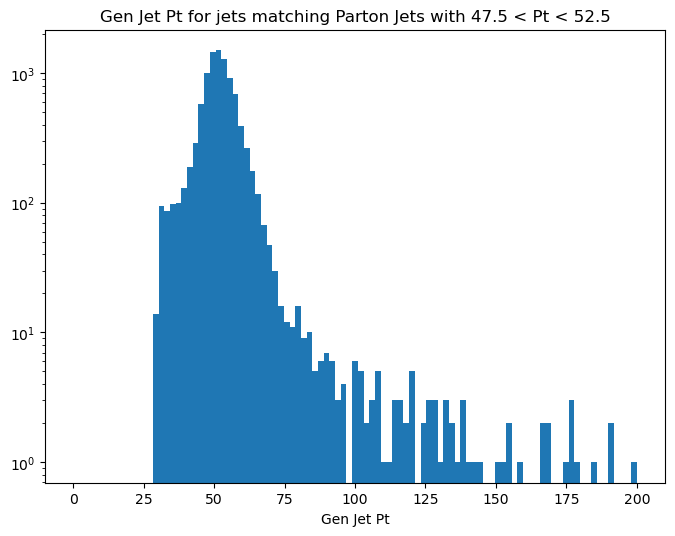

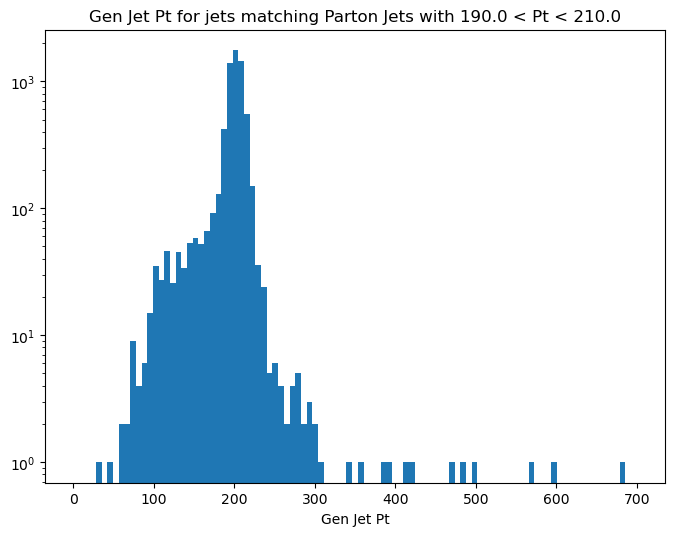

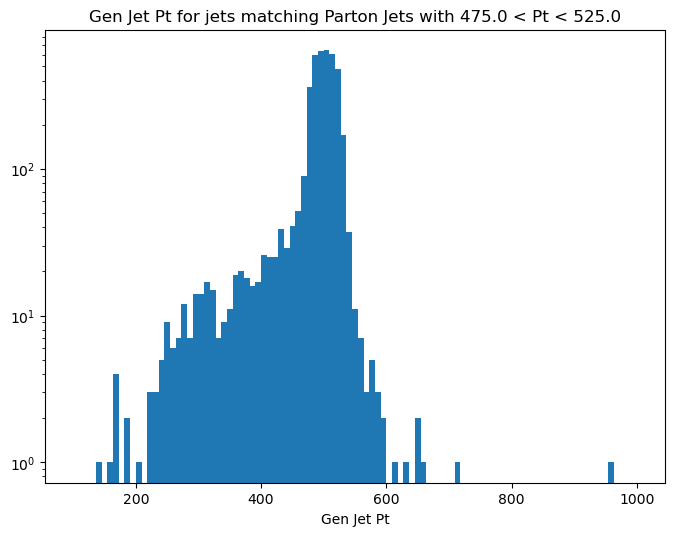

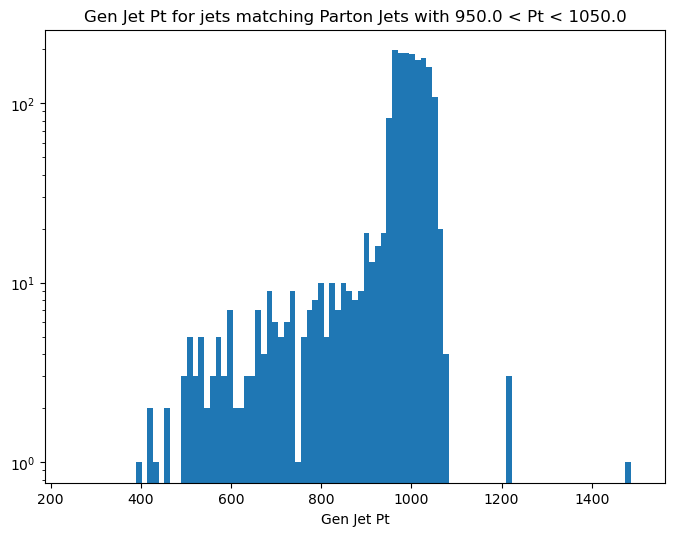

In [121]:
data = np.loadtxt("../data/txt/matchData.txt", skiprows=2)
range_highs = [200, 700, 1000, 1500]
range_lows = [0, 0, 100, 250]
j = 0
for center in [50, 200, 500, 1000]:
    pt = []
    low = center - center/20
    high = center + center/20
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            pt.append(data[i, 17])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(8,6), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(pt, bins=bins)
    ax.set_xlabel("Gen Jet Pt")
    ax.set_title("Gen Jet Pt for jets matching Parton Jets with {} < Pt < {}".format(low, high))
    ax.set_yscale('log')
    plt.show()
    fig.savefig("PtDistLog{}.png".format(j))
    j+=1

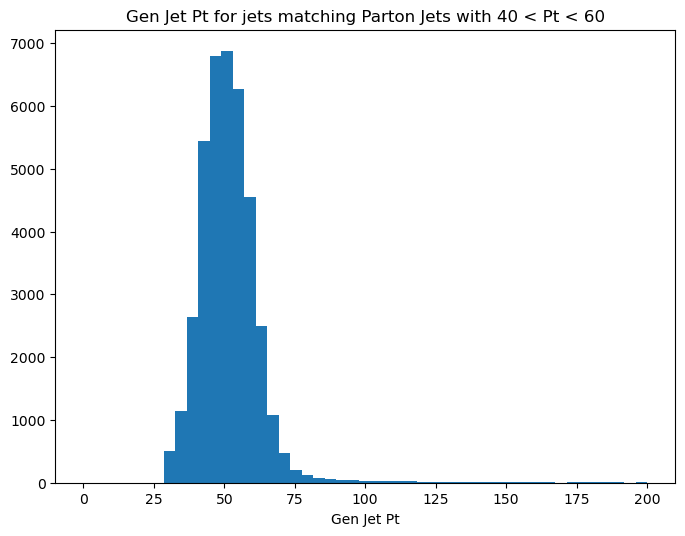

In [107]:

print(data[0])
partonPtMax = np.max(data[:, 0], axis=0)
partonPtMin = np.min(data[:, 0], axis=0)
partonMean = np.mean(data[:, 1:3], axis=0)
partonStd = np.std(data[:, 1:3], axis=0)
partonEMax = np.max(data[:, 3], axis=0)
partonEMin = np.min(data[:, 3], axis=0)

genPtMax = np.max(data[:, 17], axis=0)
genPtMin = np.min(data[:, 17], axis=0)
genMean = np.mean(data[:, 18:20], axis=0)
genStd = np.std(data[:, 18:20], axis=0)
genEMax = np.max(data[:, 20], axis=0)
genEMin = np.min(data[:, 20], axis=0)

data[:, 0] = (data[:, 0] - partonPtMin)/partonPtMax
data[:, 1:3] = (data[:, 1:3] - partonMean)/partonStd
data[:, 3] = (data[:, 3] - partonEMin)/partonEMax
data[:, 17] = (data[:, 17] - genPtMin)/genPtMax
data[:, 18:20] = (data[:, 18:20] - genMean)/genStd
data[:, 20] = (data[:, 20] - genEMin)/genEMax
print(data[0])

[ 60.9345    2.7002   -3.06532 456.018     0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        1.       60.6069    2.7125   -3.05174 458.716  ]
[ 0.00939336  1.68601595 -1.69021009  0.05536538  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.00702843
  1.68473673 -1.6830399   0.08043433]


In [108]:
#print(tf.config.list_physical_devices())
devices = tf.config.list_physical_devices()
print(len(devices[0]))

2


In [109]:
with tf.device('/CPU:0'):
    index = int(0.8*len(data))
    validate = data[index:, :]
    validateParton = validate[:, :4]
    validateInputs = validate[:, :17]
    validateGen = validate[:, 17:]
    mae = keras.losses.MeanAbsoluteError()
    naiveErr = mse(validateParton, validateGen).numpy()
    print(naiveErr)

0.008199090138077736


In [110]:
checkpoint_path = save_dir + 'training/cp.cpkt'
with tf.device('/CPU:0'):
    net = model.make_model()
    net.summary()
    mse = keras.losses.MeanSquaredError()
    net.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
           loss=mse,
           metrics=[keras.metrics.MeanAbsoluteError()])
    net.load_weights(checkpoint_path)
    prediction = net.predict(validateInputs)
    net.evaluate(validateInputs, validateGen, batch_size=128)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               2304      
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 516       
Total params: 68,868
Trainable params: 68,868
Non-trainable params: 0
__________________________________________________

In [111]:
mae = keras.losses.MeanAbsoluteError()

print(validate[0, 0])
validate[:, 0] = (validate[:, 0])*partonPtMax + partonPtMin
validate[:, 1:3] = (validate[:, 1:3])*partonStd + partonMean
validate[:, 3] = (validate[:, 3])*partonEMax + partonEMin

validate[:, 17] = (validate[:, 17])*genPtMax + genPtMin
validate[:, 18:20] = (validate[:, 18:20])*genStd + genMean
validate[:, 20] = (validate[:, 20])*genEMax + genEMin

inputs = validate[:, :4]

print(prediction[0, 0])
prediction[:, 0] = (prediction[:, 0])*genPtMax + genPtMin
prediction[:, 1:3] = prediction[:, 1:3]*genStd + genMean
prediction[:, 3] = (prediction[:, 3])*genEMax + genEMin
true = validate[:, 17:]
print(prediction[0, 0])


0.07856195126876529
0.07684816
364.6509


In [112]:
print(prediction[0])
print(true[0])

[3.6465091e+02 1.7535854e-02 2.0276759e+00 3.6049606e+02]
[3.66417e+02 1.18268e-02 2.02261e+00 3.67738e+02]


In [113]:
with tf.device('/CPU:0'):    
    #calculate MAEs between components of parton and gen jets
    naivePxErr = mae(inputs[:, 0], true[:, 0]).numpy()
    print(naivePxErr)
    naivePyErr = mae(inputs[:, 1], true[:, 1]).numpy()
    print(naivePyErr)
    naivePzErr = mae(inputs[:, 2], true[:, 2]).numpy()
    print(naivePzErr)
    naiveEErr = mae(inputs[:, 3], true[:, 3]).numpy()
    print(naiveEErr)
    #naivePtErr = mae(np.sqrt((inputs[:, 0])**2 + (inputs[:, 1]**2)), np.sqrt((true[:, 0])**2 + (true[:, 1]**2))).numpy()
    #print(naivePtErr)

12.182266235351562
0.01771245338022709
0.030493592843413353
31.661231994628906


In [114]:
#calculate MAEs between components of predicted and gen jets
predPxErr = mae(prediction[:, 0], true[:, 0]).numpy()
print(predPxErr)
predPyErr = mae(prediction[:, 1], true[:, 1]).numpy()
print(predPyErr)
predPzErr = mae(prediction[:, 2], true[:, 2]).numpy()
print(predPzErr)
predEErr = mae(prediction[:, 3], true[:, 3]).numpy()
print(predEErr)
predPtErr = mae(np.sqrt((prediction[:, 0])**2 + (prediction[:, 1]**2)), np.sqrt((true[:, 0])**2 + (true[:, 1]**2))).numpy()
print(predPtErr)

12.098855018615723
0.01695547252893448
0.031314246356487274
29.452322006225586
12.094965934753418


In [15]:
pt_err_close = []
pt_err_far = []
pt_pred_close = []
pt_true_close = []
pt_pred_far = []
pt_true_far = []
for i in range(len(prediction)):
    if (((inputs[i, 1] - true[i, 1])**2 + (inputs[i, 2] - inputs[i, 2])**2)**(1/2) < 0.01):
        pt_err_close.append(abs(prediction[i, 0] - true[i, 0]))
        pt_true_close.append(true[i, 0])
        pt_pred_close.append(prediction[i, 0])
    else:
        pt_err_far.append(abs(prediction[i, 0] - true[i, 0]))
        pt_true_far.append(true[i, 0])
        pt_pred_far.append(prediction[i, 0])
    

In [16]:
print(np.mean(pt_err_close))
print(np.mean(pt_err_far))

12.62932911658494
12.093468165193203


In [17]:
ratio_close = np.array(pt_pred_close)/np.array(pt_true_close)
ratio_far = np.array(pt_pred_far)/np.array(pt_true_far)

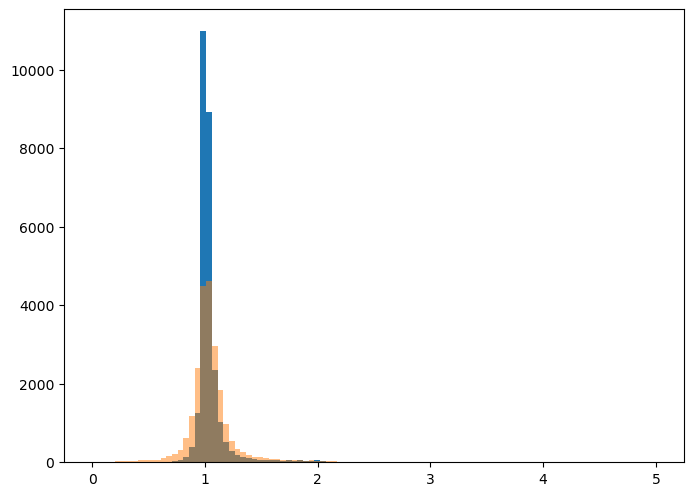

In [18]:
bins = np.linspace(0, 5, 100)
fig = plt.figure(figsize=(8,6), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(ratio_close, bins=bins)
ax1.hist(ratio_far, bins=bins, alpha=0.5)
plt.show()

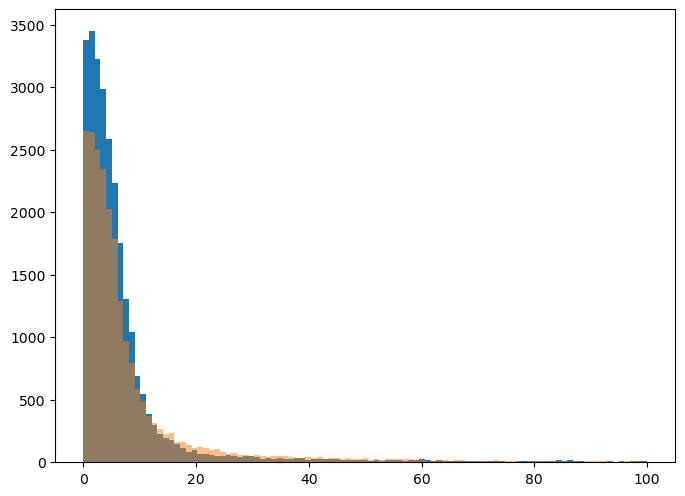

In [19]:
bins = np.linspace(0, 100, 100)
fig = plt.figure(figsize=(8,6), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(pt_err_close, bins=bins)
ax1.hist(pt_err_far, bins=bins, alpha=0.5)
plt.show()

In [20]:
percent_errs = abs((inputs - true)/true * 100)
print(np.mean(percent_errs, axis=0))
percent_errs = abs((prediction - true)/true * 100)
print(np.mean(percent_errs, axis=0))

[9.38442062 7.83436405 7.80896314 9.69380999]
[9.34216743 8.27240574 7.79119374 8.95506489]


In [21]:
px_err_parts = []
py_err_parts = []
pz_err_parts = []
E_err_parts = []
px_err_preds = []
py_err_preds = []
pz_err_preds = []
E_err_preds = []

px_mae_parts = []
py_mae_parts = []
pz_mae_parts = []
E_mae_parts = []
px_mae_preds = []
py_mae_preds = []
pz_mae_preds = []
E_mae_preds = []
true_pt = (np.sqrt((true[:, 0])**2 + (true[:, 1])**2))
for i in range(len(true)):
    if true_pt[i] > 0:
        px_err_parts.append(abs((inputs[i, 0] - true[i, 0])/true[i, 0])*100)
        py_err_parts.append(abs((inputs[i, 1] - true[i, 1])/true[i, 1])*100)
        pz_err_parts.append(abs((inputs[i, 2] - true[i, 2])/true[i, 2])*100)
        E_err_parts.append(abs((inputs[i, 3] - true[i, 3])/true[i, 3])*100)
        
        px_err_preds.append(abs((prediction[i, 0] - true[i, 0])/true[i, 0])*100)
        py_err_preds.append(abs((prediction[i, 1] - true[i, 1])/true[i, 1])*100)
        pz_err_preds.append(abs((prediction[i, 2] - true[i, 2])/true[i, 2])*100)
        E_err_preds.append(abs((prediction[i, 3] - true[i, 3])/true[i, 3])*100)
        
        px_mae_parts.append(abs(inputs[i, 0] - true[i, 0]))
        py_mae_parts.append(abs(inputs[i, 1] - true[i, 1]))
        pz_mae_parts.append(abs(inputs[i, 2] - true[i, 2]))
        E_mae_parts.append(abs(inputs[i, 3] - true[i, 3]))
        
        px_mae_preds.append(abs(prediction[i, 0] - true[i, 0]))
        py_mae_preds.append(abs(prediction[i, 1] - true[i, 1]))
        pz_mae_preds.append(abs(prediction[i, 2] - true[i, 2]))
        E_mae_preds.append(abs(prediction[i, 3] - true[i, 3]))
        
print(np.mean(px_err_parts))
print(np.mean(py_err_parts))
print(np.mean(pz_err_parts))
print(np.mean(E_err_parts))
print()

print(np.mean(px_err_preds))
print(np.mean(py_err_preds))
print(np.mean(pz_err_preds))
print(np.mean(E_err_preds))
print()

print(np.mean(px_mae_parts))
print(np.mean(py_mae_parts))
print(np.mean(pz_mae_parts))
print(np.mean(E_mae_parts))
print()

print(np.mean(px_mae_preds))
print(np.mean(py_mae_preds))
print(np.mean(pz_mae_preds))
print(np.mean(E_mae_preds))
        
        

9.384420619650244
7.834364045129116
7.808963136232811
9.693809988285432

9.342167432252776
8.272405736827768
7.791193741193423
8.955064886360905

12.182266187916232
0.01771245411358421
0.0304935919141569
31.661231290620236

12.38548723095705
0.016585802700225874
0.030788280601819998
29.45672677387243


## Histograms of Pt

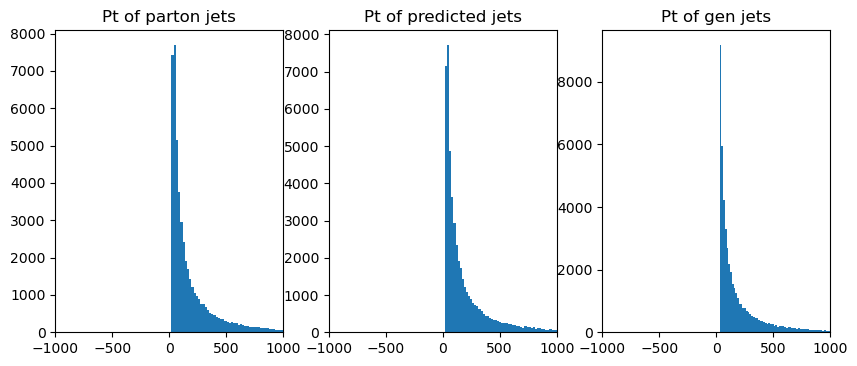

In [115]:
fig = plt.figure(figsize=(10,4), dpi=100)
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 0], bins=200)
ax1.set_title("Pt of parton jets")
ax1.set_xlim(-1000, 1000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 0], bins=200)
ax2.set_title("Pt of predicted jets")
ax2.set_xlim(-1000, 1000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 0], bins=200)
ax3.set_title("Pt of gen jets")
ax3.set_xlim(-1000, 1000)
#plt.yscale('log')
plt.show()

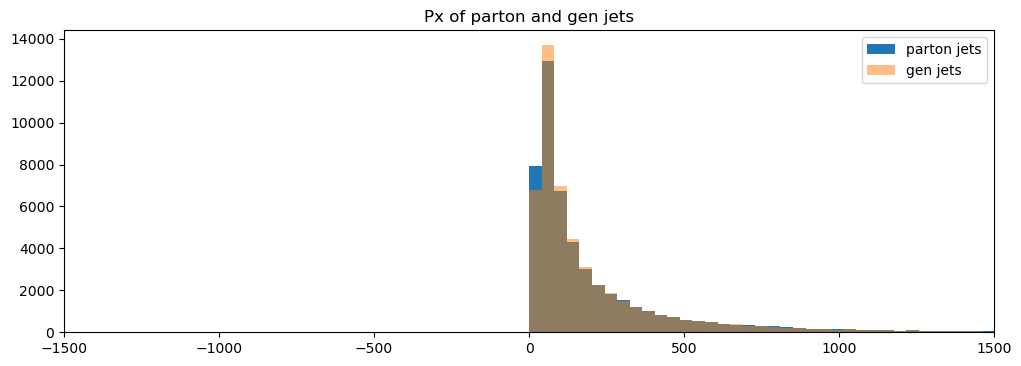

In [116]:
bins = np.linspace(-1500, 1500, 75)
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 0], bins=bins, label='parton jets')
ax1.hist(true[:, 0], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Px of parton and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

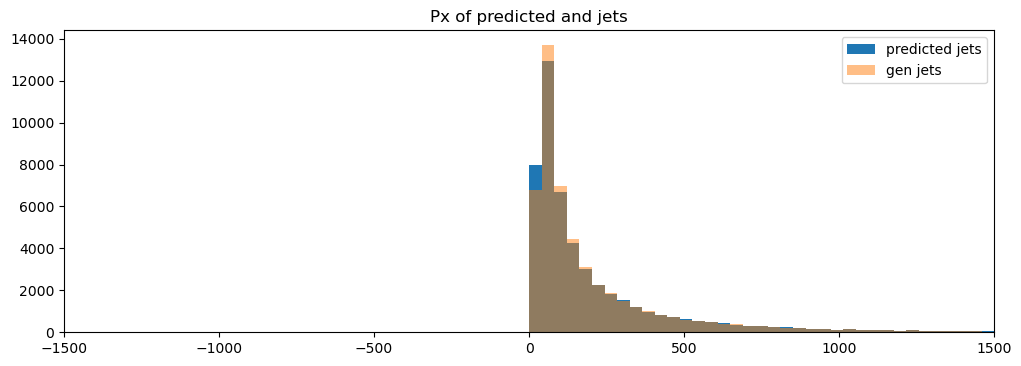

In [117]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 0], bins=bins, label='predicted jets')
ax1.hist(true[:, 0], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Px of predicted and jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

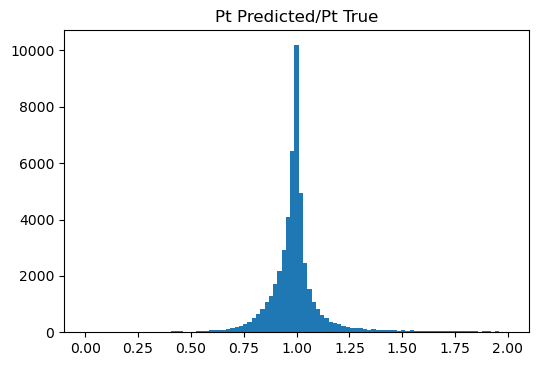

In [118]:
bins = np.linspace(0.0, 2, 100)
fig = plt.figure(figsize=(6,4), dpi=100)
ax1 = fig.add_subplot(111)
ratios = prediction[:, 0] / true[:, 0]
ax1.hist(ratios, bins=bins)
ax1.set_title("Pt Predicted/Pt True")
plt.show()

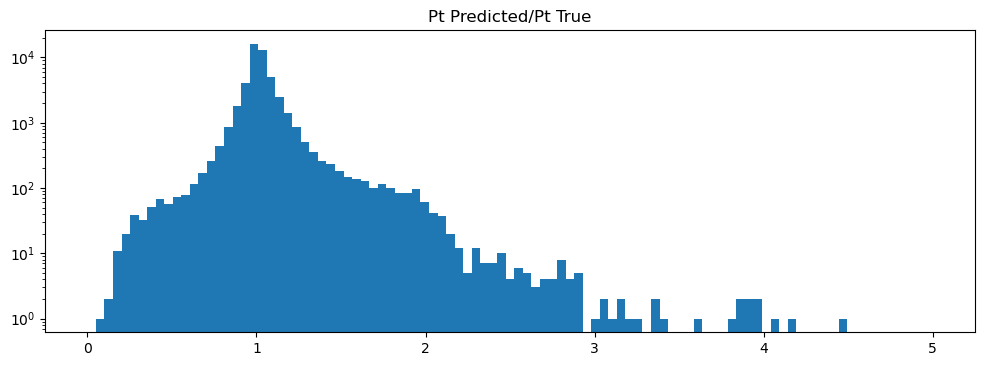

In [26]:
bins = np.linspace(0.0, 5, 100)
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ratios = prediction[:, 0] / true[:, 0]
ax1.hist(ratios, bins=bins)
ax1.set_title("Pt Predicted/Pt True")
ax1.set_yscale('log')
plt.show()

Text(0, 0.5, 'Pred Pt/True Pt')

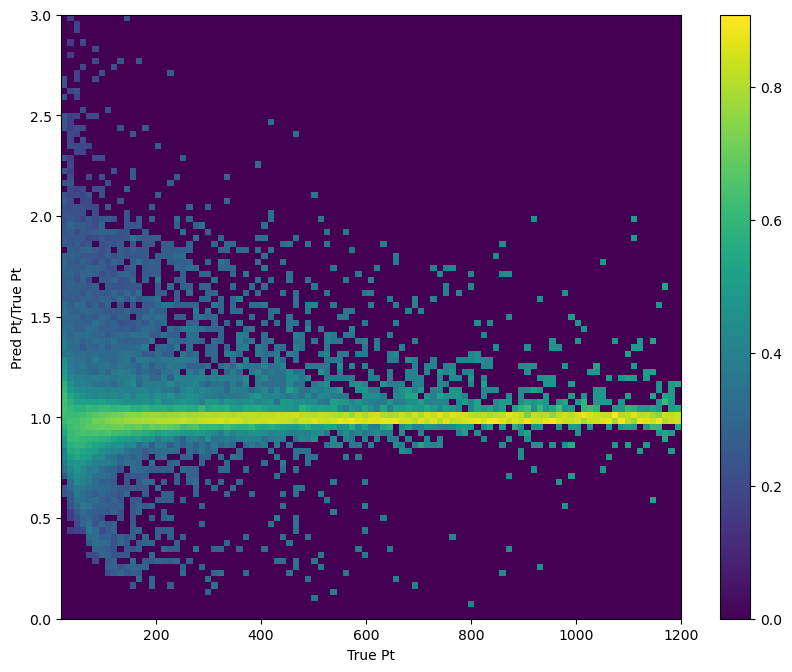

In [120]:
#bins1 = np.linspace(0.0, 5, 100)
#bins2 = np.linspace(0, 1000, 100)
fig = plt.figure(figsize=(10,8), dpi=100)
ax1 = fig.add_subplot(111)
ratios = prediction[:, 0] / true[:, 0]
ratio_bins = np.linspace(0, 3.0, 100)
pt_bins = np.linspace(20, 1200, 100)
h2, xbins, ybins = np.histogram2d(true[:, 0], ratios, bins=(pt_bins, ratio_bins))

for i in range(len(h2)):
    if (sum(h2[i]) > 0):
        h2[i] /= sum(h2[i])
        h2[i] = (h2[i])**(1/5)
h2 = np.transpose(h2)
plt.imshow(h2, origin='lower', extent=[20, 1200, 0, 3.0], aspect='auto')
#plt.ylim(0, 3)
plt.colorbar()
plt.xlabel("True Pt")
plt.ylabel("Pred Pt/True Pt")
#print(h2[8])
#print(sum(h2[2]))
#print(h2[:, 4])
#h = ax1.hist2d(true[:, 0], ratios, bins=100, norm=mpl.colors.PowerNorm(0.15))
#ax1.hist2d(true[:, 0], ratios, bins=100)
#ax1.hist(true[:, 0])
#h = ax1.hist2d(ratios, true[:, 0], bins=100, norm=mpl.colors.Normalize())
#ax1.set_ylim(0.1, 3)
#ax1.set_xlim(30, 1000)
#ax1.set_ylabel("Predicted Pt / True Pt")
#ax1.set_xlabel("True Pt")
#ax1.set_title("Pt Predicted/Pt True")
#ax1.set_yscale('log')
#plt.colorbar(h[3], ax=ax1, ticks=(0, 5, 10, 50, 100, 500, 1000, 3000))
#plt.show()

51.4072
49.458305
52.64462188621219
49.435547


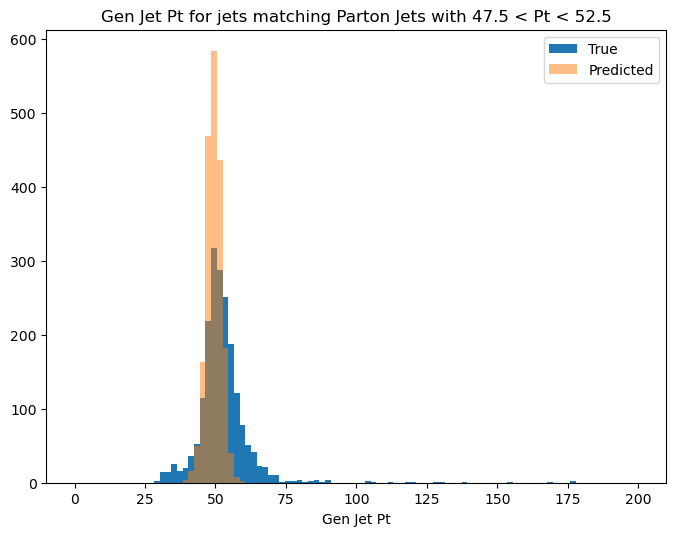

200.4615
200.435
197.88981340125392
199.95142


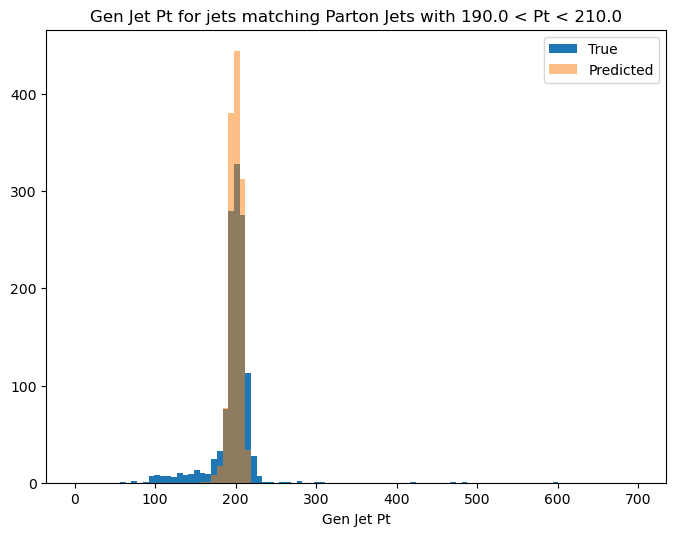

496.71450000000004
499.33743
487.46437046632127
499.4213


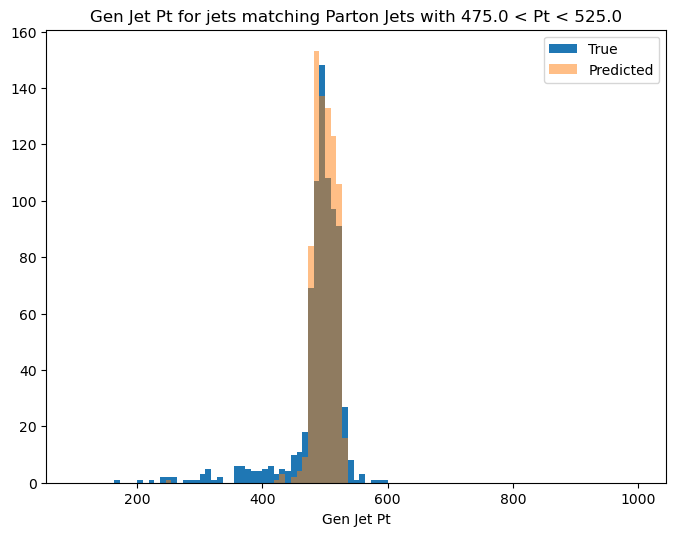

992.238
1001.9588
970.0564261363635
996.7025


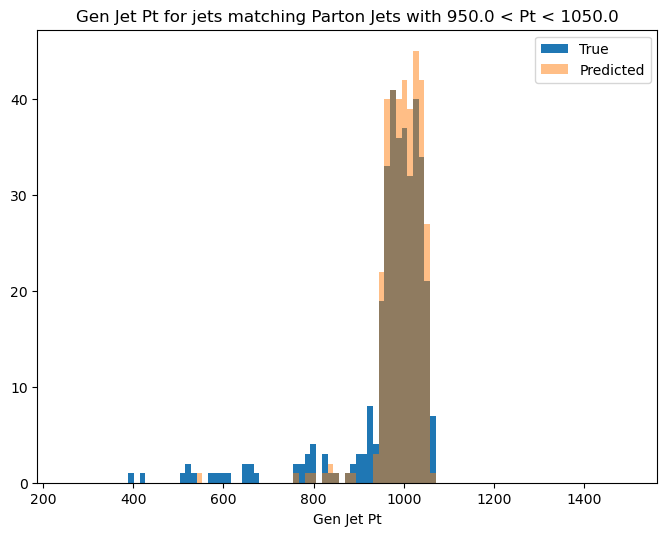

In [132]:
range_highs = [200, 700, 1000, 1500]
range_lows = [0, 0, 100, 250]
j = 0
for center in [50, 200, 500, 1000]:
    pt_true = []
    pt_predicted = []
    low = center - center/20
    high = center + center/20
    for i in range(len(validate)):
        if (validate[i, 0] > low and validate[i, 0] < high):
            pt_true.append(validate[i, 17])
            pt_predicted.append(prediction[i, 0])
    print(np.median(pt_true))
    print(np.median(pt_predicted))
    print(np.mean(pt_true))
    print(np.mean(pt_predicted))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(8,6), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(pt_true, bins=bins, label='True')
    ax.hist(pt_predicted, bins=bins, label='Predicted', alpha=0.5)
    ax.legend()
    ax.set_xlabel("Gen Jet Pt")
    ax.set_title("Gen Jet Pt for jets matching Parton Jets with {} < Pt < {}".format(low, high))
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig("PtDistLog{}.png".format(j))
    j+=1

## Histograms of Py

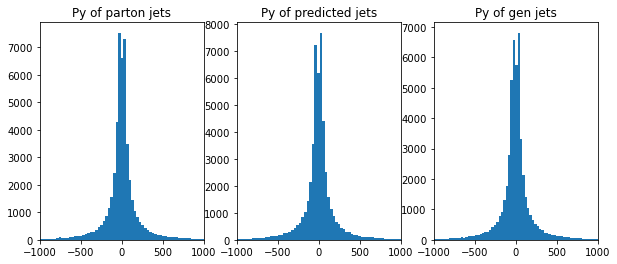

In [19]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 1], bins=200)
ax1.set_title("Py of parton jets")
ax1.set_xlim(-1000, 1000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 1], bins=200)
ax2.set_title("Py of predicted jets")
ax2.set_xlim(-1000, 1000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 1], bins=200)
ax3.set_title("Py of gen jets")
ax3.set_xlim(-1000, 1000)
#plt.yscale('log')
plt.show()

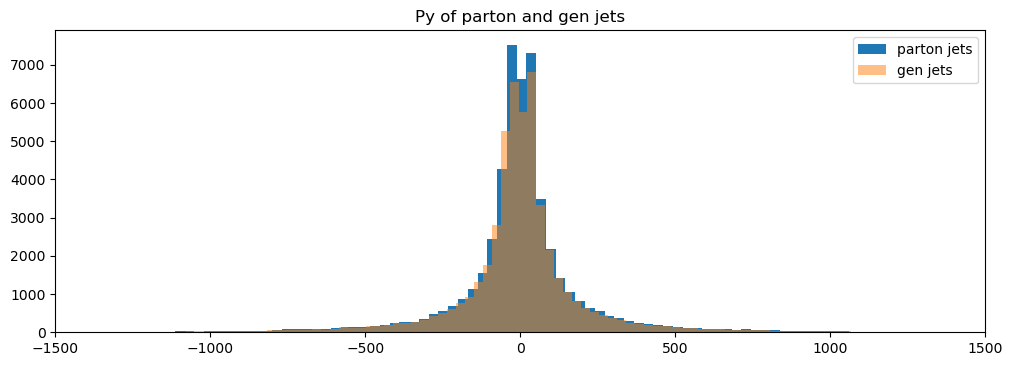

In [20]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 1], bins=200, label='parton jets')
ax1.hist(true[:, 1], bins=200, label='gen jets', alpha=0.5)
ax1.set_title("Py of parton and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

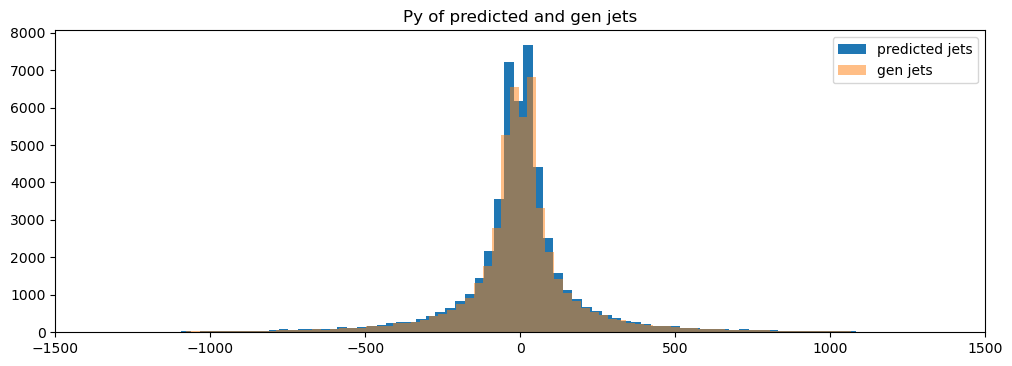

In [21]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 1], bins=200, label='predicted jets')
ax1.hist(true[:, 1], bins=200, label='gen jets', alpha=0.5)
ax1.set_title("Py of predicted and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

## Histograms for Pz

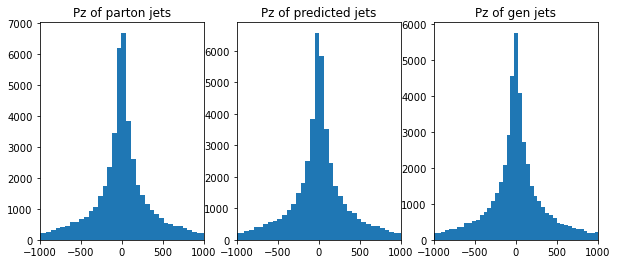

In [22]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 2], bins=200)
ax1.set_title("Pz of parton jets")
ax1.set_xlim(-1000, 1000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 2], bins=200)
ax2.set_title("Pz of predicted jets")
ax2.set_xlim(-1000, 1000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 2], bins=200)
ax3.set_title("Pz of gen jets")
ax3.set_xlim(-1000, 1000)
#plt.yscale('log')
plt.show()

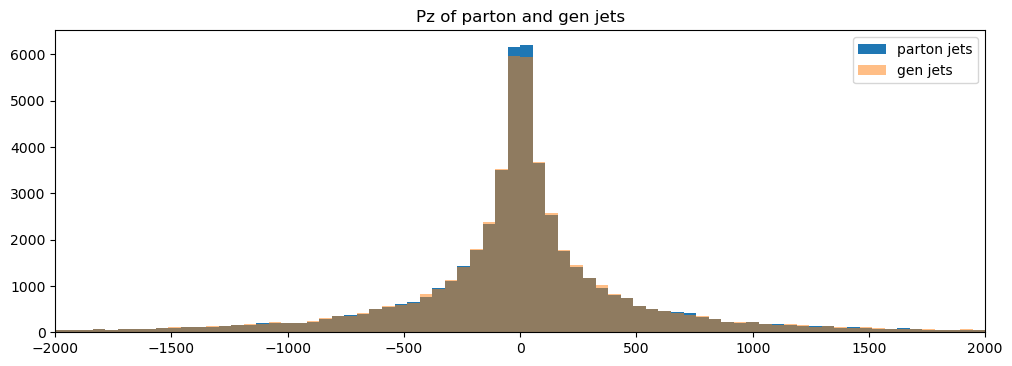

In [23]:
bins = np.linspace(-2000, 2000, 75)
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 2], bins=bins, label='parton jets')
ax1.hist(true[:, 2], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Pz of parton and gen jets")
ax1.set_xlim(-2000, 2000)
ax1.legend()
plt.show()

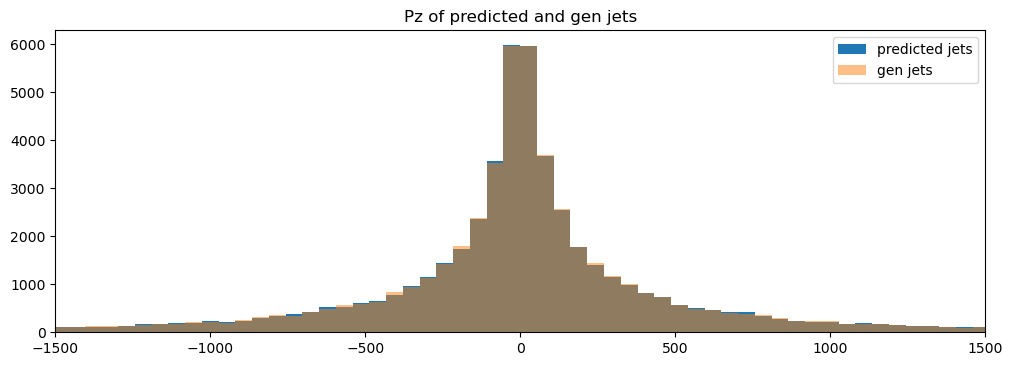

In [24]:
fig = plt.figure(figsize=(12,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 2], bins=bins, label='predicted jets')
ax1.hist(true[:, 2], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("Pz of predicted and gen jets")
ax1.set_xlim(-1500, 1500)
ax1.legend()
plt.show()

## Energy histograms

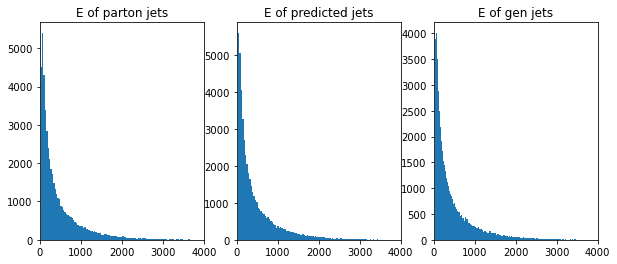

In [25]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(inputs[:, 3], bins=200)
ax1.set_title("E of parton jets")
ax1.set_xlim(0, 4000)
ax2 = fig.add_subplot(132)
ax2.hist(prediction[:, 3], bins=200)
ax2.set_title("E of predicted jets")
ax2.set_xlim(0, 4000)
ax3 = fig.add_subplot(133)
ax3.hist(true[:, 3], bins=200)
ax3.set_title("E of gen jets")
ax3.set_xlim(0, 4000)
#plt.yscale('log')
plt.show()

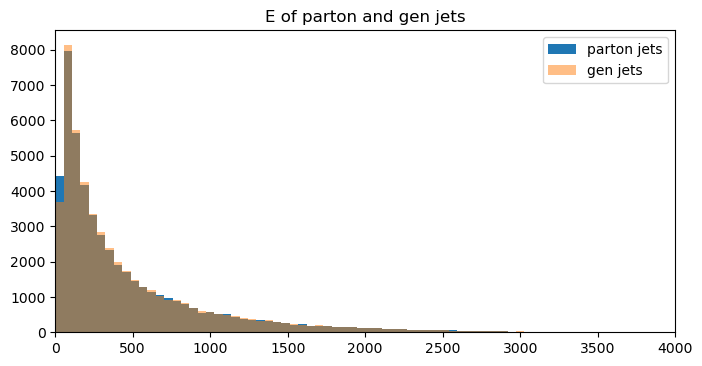

In [26]:
bins = np.linspace(0, 4000, 75)
fig = plt.figure(figsize=(8,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(inputs[:, 3], bins=bins, label='parton jets')
ax1.hist(true[:, 3], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("E of parton and gen jets")
ax1.set_xlim(0, 4000)
ax1.legend()
plt.show()

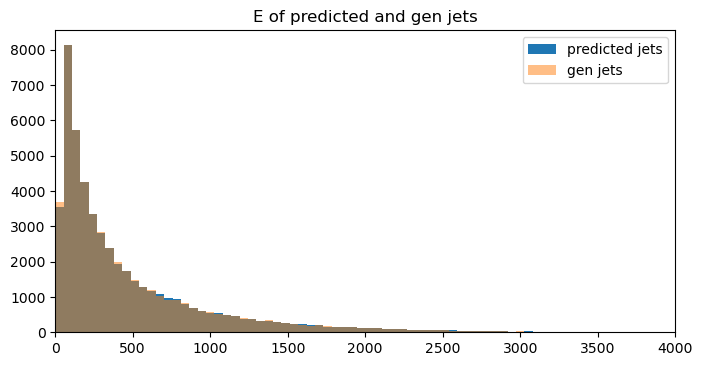

In [27]:
fig = plt.figure(figsize=(8,4), dpi=100)
ax1 = fig.add_subplot(111)
ax1.hist(prediction[:, 3], bins=bins, label='predicted jets')
ax1.hist(true[:, 3], bins=bins, label='gen jets', alpha=0.5)
ax1.set_title("E of predicted and gen jets")
ax1.set_xlim(0, 4000)
ax1.legend()
plt.show()

## Pt histograms

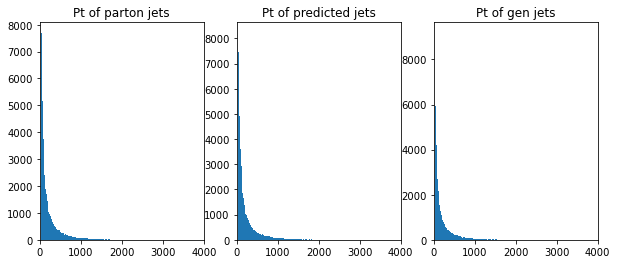

In [28]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131)
ax1.hist(np.sqrt((inputs[:, 0])**2 + (inputs[:, 1])**2), bins=200)
ax1.set_title("Pt of parton jets")
ax1.set_xlim(0, 4000)
ax2 = fig.add_subplot(132)
ax2.hist(np.sqrt((prediction[:, 0])**2 + (prediction[:, 1])**2), bins=200)
ax2.set_title("Pt of predicted jets")
ax2.set_xlim(0, 4000)
ax3 = fig.add_subplot(133)
ax3.hist(np.sqrt((true[:, 0])**2 + (true[:, 1])**2), bins=200)
ax3.set_title("Pt of gen jets")
ax3.set_xlim(0, 4000)
#plt.yscale('log')
plt.show()

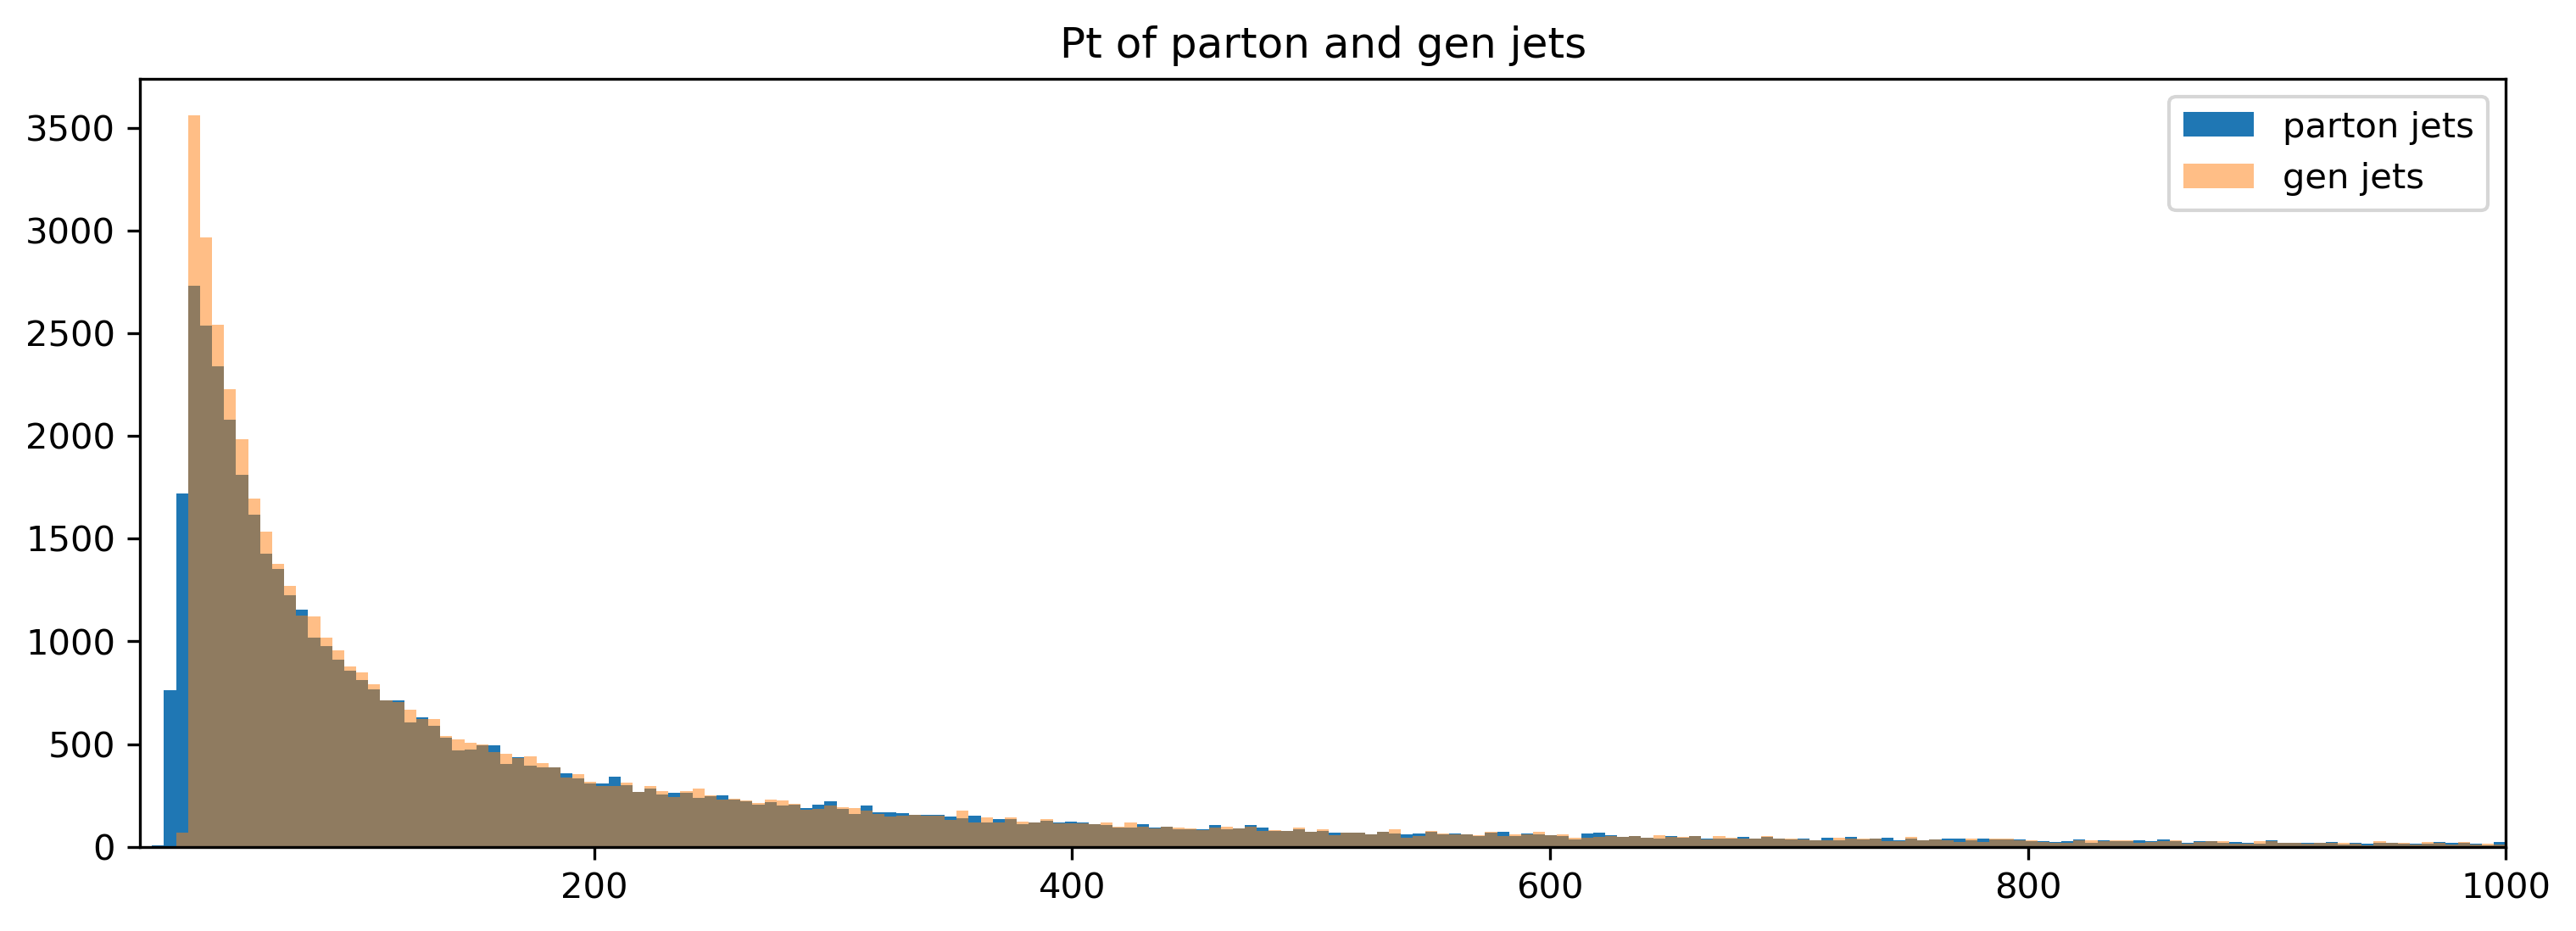

In [36]:
bins_spacing = np.linspace(10, 1000, 198)
fig = plt.figure(figsize=(12,4), dpi=300)
ax1 = fig.add_subplot(111)
ax1.hist(np.sqrt((inputs[:, 0])**2 + (inputs[:, 1])**2), bins=bins_spacing, label='parton jets')
ax1.hist(np.sqrt((true[:, 0])**2 + (true[:, 1])**2), bins=bins_spacing, label='gen jets', alpha=0.5)
ax1.set_title("Pt of parton and gen jets")
ax1.set_xlim(10, 1000)
ax1.legend()
plt.show()

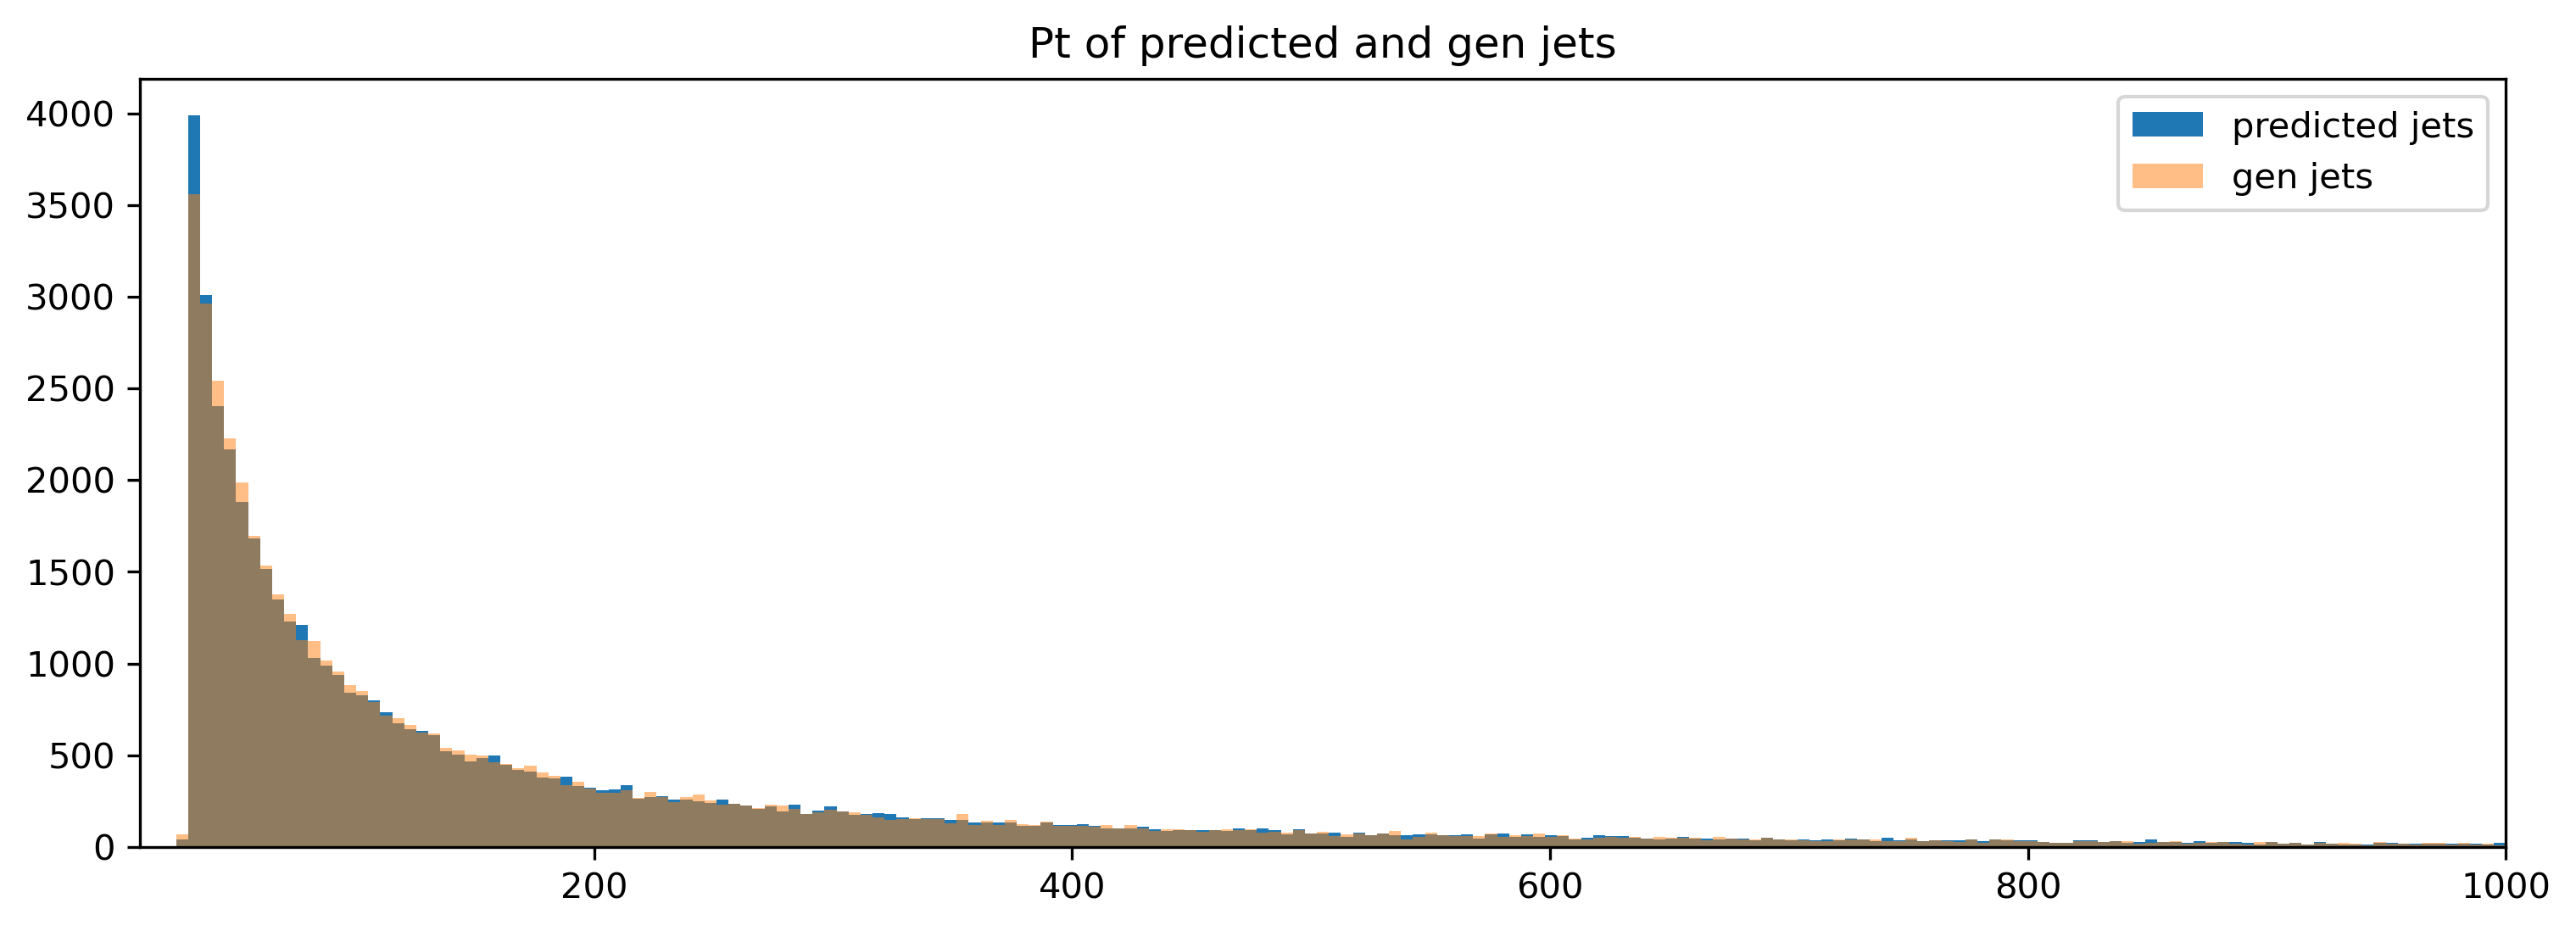

In [38]:
fig = plt.figure(figsize=(12,4), dpi=300)
ax1 = fig.add_subplot(111)
ax1.hist(np.sqrt((prediction[:, 0])**2 + (prediction[:, 1])**2), bins=bins_spacing, label='predicted jets')
ax1.hist(np.sqrt((true[:, 0])**2 + (true[:, 1])**2), bins=bins_spacing, label='gen jets', alpha=0.5)
ax1.set_title("Pt of predicted and gen jets")
ax1.set_xlim(10, 1000)
ax1.legend()
plt.show()

## Calculating delta R

In [31]:
def theta(vec):
    pt = np.sqrt((vec[:, 0])**2 + (vec[:, 1])**2)
    return np.arctan2(pt, vec[:, 2])

def phi(vec):
    return np.arctan2(vec[:, 1], vec[:, 0])

def eta(vec):
    return -np.log(np.tan(theta(vec)/2))

def deltaR(vec1, vec2):
    return (np.sqrt((eta(vec1)-eta(vec2))**2 + (phi(vec1)-phi(vec2))**2))

#testing theta - should return [0.693, 0.549]
arr = np.array(([1, 2, 3, 5],[3, -1, 4, 8]), dtype=float)
print(theta(arr))
print(phi(arr))

[0.64052231 0.66896407]
[ 1.10714872 -0.32175055]


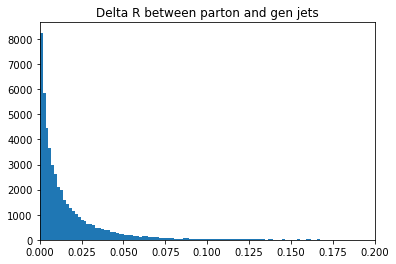

In [134]:
deltaRPartonsGen = ((inputs[:, 1] - true[:, 1])**2 + (inputs[:, 2] - inputs[:, 2])**2)**(1/2)
#print(deltaRPartonsGen.shape)
plt.hist(deltaRPartonsGen, bins=200)
plt.xlim(0,0.2)
plt.title("Delta R between parton and gen jets")
plt.show()

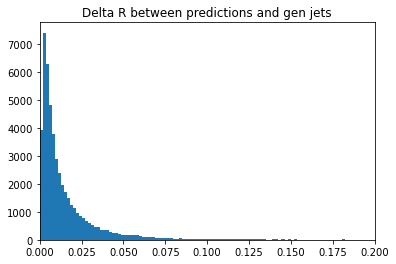

In [135]:
deltaRPredictionGen = ((prediction[:, 1] - true[:, 1])**2 + (prediction[:, 2] - inputs[:, 2])**2)**(1/2)
#print(deltaRPartonsGen.shape)
plt.hist(deltaRPredictionGen, bins=200)
plt.xlim(0,0.2)
plt.title("Delta R between predictions and gen jets")
plt.show()

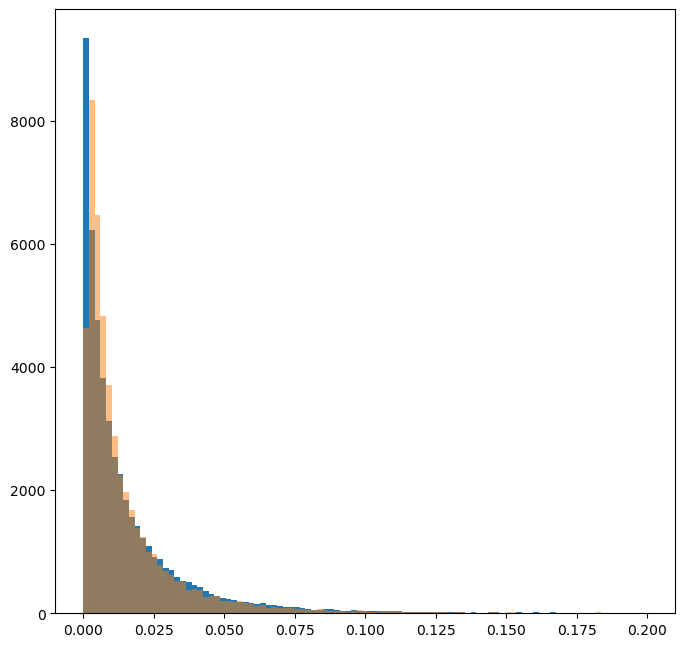

In [142]:
bins = np.linspace(0, 0.2, 100)
fig = plt.figure(figsize=(8,8), dpi=100)
plt.hist(deltaRPartonsGen, bins=bins)
plt.hist(deltaRPredictionGen, bins=bins, alpha=0.5)
plt.show()